# Review-Based QA System
------ 

Can you get the answers of specifc questions like “does this guitar come with a strap?” or “can I use this camera at night?” when you want to buy these products online?

It may be hard to answer from the product description alone.

One alternative is to post your question on the community QA platforms provided by websites like Amazon, but it usually takes days to get an answer (if at all).

It would be nice if we get an immediate answer like the Google Example below

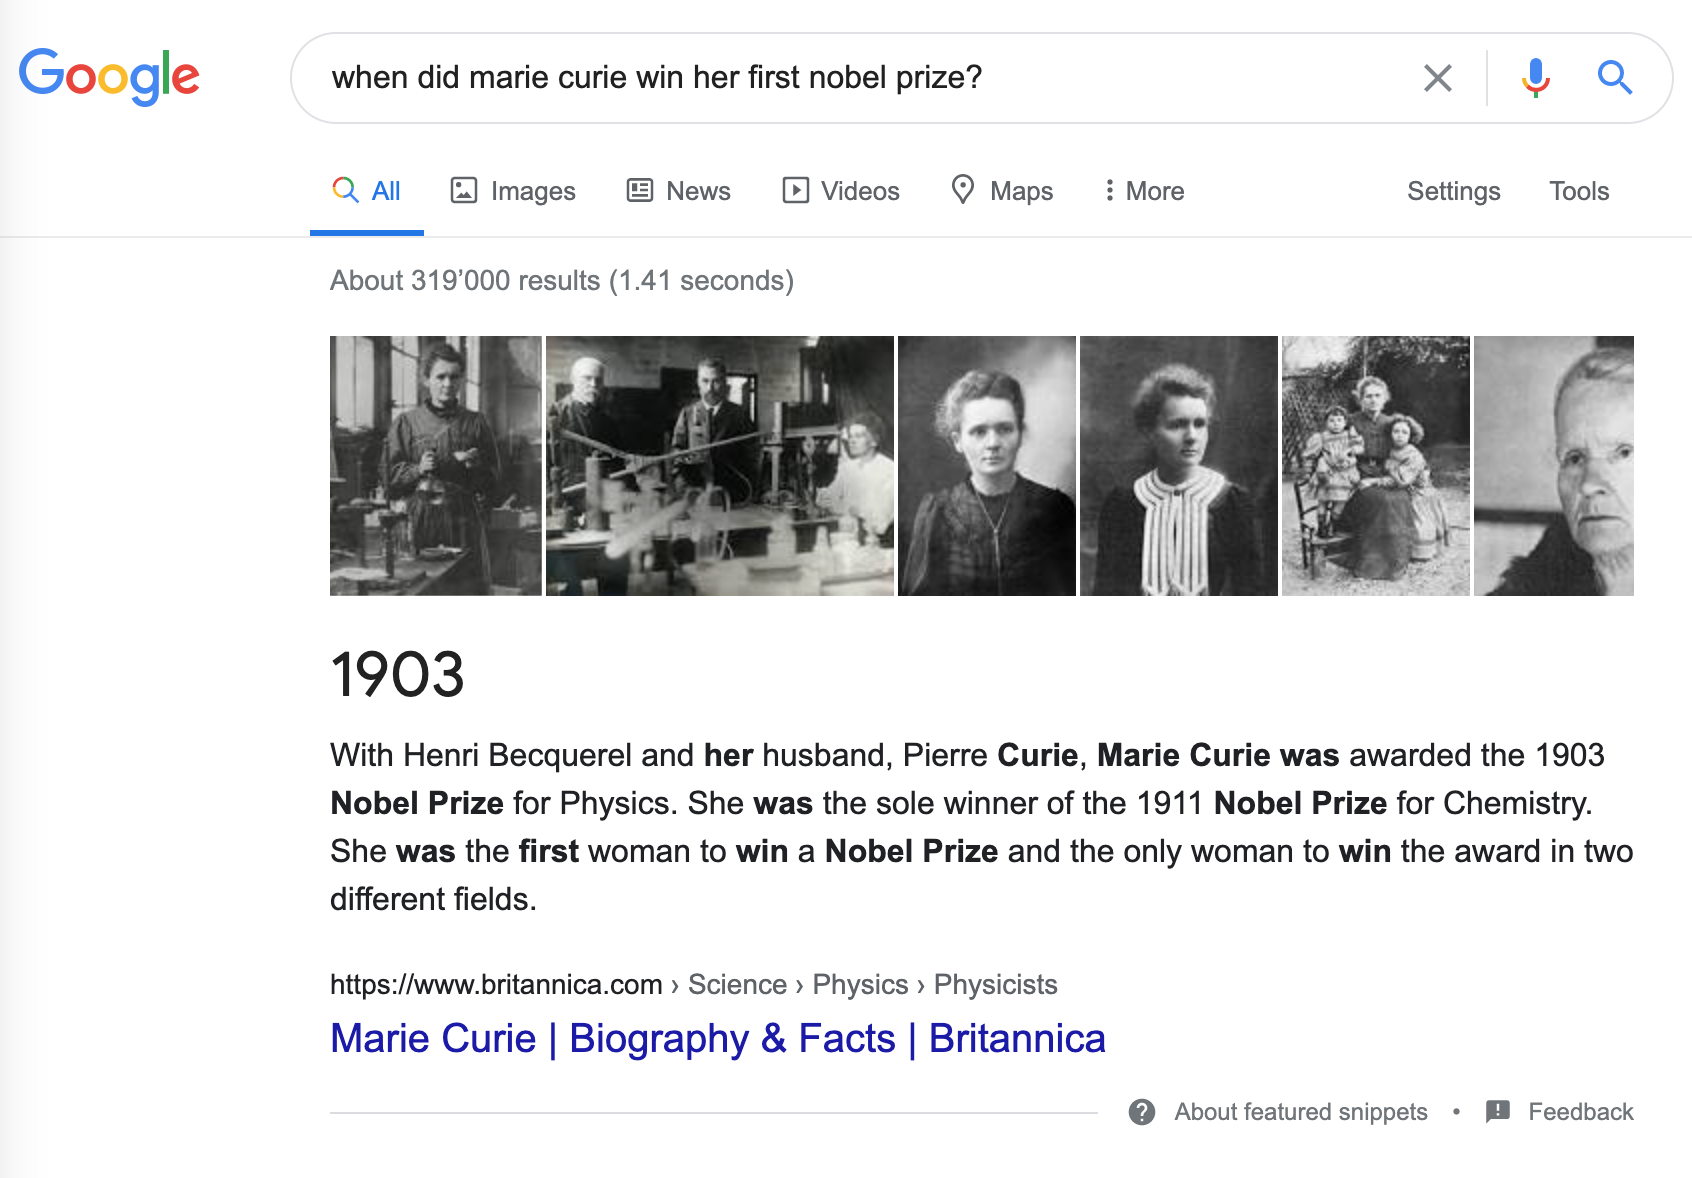

## Objective
------

To predict the answers of the question asked by the users by using the reviews of those products.

## The Dataset
--------

To build our QA system, we'll use SubjQA dataset which has 10K customer reviews in English about products and services in the areas of TripAdvisor, Restaurants, Movies, Books, Electronics, and Grocery. 

Firstly we'll focus on bulding the QA for the Electronics Domain, Lets' download the data from [Hugging Face Hub](https://huggingface.co/datasets/subjqa)

In [1]:
from datasets import load_dataset
import pandas as pd

subjqa = load_dataset("subjqa", "electronics")
subjqa.set_format("pandas")
# Flatten the nested dataset columns for easy access
dfs = {split:ds[:] for split, ds in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Reusing dataset subjqa (/home/ma/sparsh/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


  0%|          | 0/3 [00:00<?, ?it/s]

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


We can notice that dataset is quite small with just 1908 examples, it cna simulate the real world scenario where we don't get much data as it quite labor-intensive and time consuming.

### Data Description

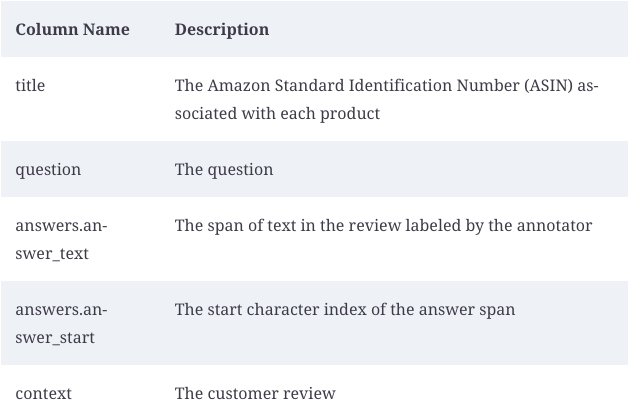

Lets check few examples of the Data

In [2]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(5, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...
961,B0074BW614,How is the cell phone screen?,[The interface takes a few tries to get used t...,[535],"Don't get me wrong, I love my e-ink kindle to ..."
1188,B00BGGDVOO,Do you have any computer with mouse?,[],[],After deciding to ditch cable TV I started to ...
999,B007P4VOWC,How is the camera?,[],[],I purchased the Tab 2 for my fianc&eacute; and...


From above examples we can make some observations:
- In answers.text are empty wehere labeler cant find the answers of the asked questions from the review context
- We can use the answers.answer_start to trace the answer from the context.

Let's check what type of questions are in the training set

In [25]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, show  
from bokeh.resources import INLINE
output_notebook(resources=INLINE)
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]
print(counts)
from bokeh.plotting import figure, output_file, show
xvals = list(counts.keys())
yvals = list(counts.values())
fig = figure(x_range = xvals, plot_width = 400, plot_height = 300)
#cols = ['navy','cyan','orange']
fig.vbar(x = xvals, top = yvals, width = 0.5)
show(fig)

Loading BokehJS ...

{'What': 236, 'How': 780, 'Is': 100, 'Does': 45, 'Do': 83, 'Was': 12, 'Where': 28, 'Why': 21}


We can observe that questions beginning with "How", "What", and "Is" are the most asked question, others are few in numbers. Let's check how these questions look like?

In [52]:
for question_type in ["How", "What", "Is"]:
    for question in dfs['train'].query("question.str.contains('%s')"%question_type, engine='python').sample(n=3, random_state=42)['question']:
        print(question)
    print()

How is the camera?
How do you like the control?
How fast is the charger?

What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?

Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?



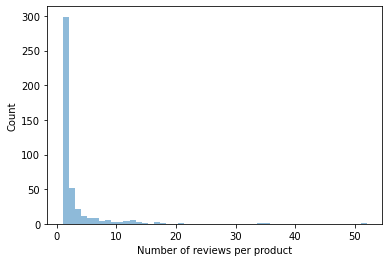

In [60]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
(dfs["train"].groupby("title")["review_id"].nunique().hist(bins=50, alpha=0.5, grid=False, ax=ax))
plt.xlabel("Number of reviews per product")
plt.ylabel("Count");